## VdP Iterative resolution & error propagation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
#from sklearn.metrics import mean_squared_error
import os

def calculate_sheet_resistance_vdp(R_A, R_B, delta=0.0005, max_iterations=1000) -> float:
    # Initial z_i, or z_0
    z_prev = (2 * np.log(2)) / (np.pi * (R_A + R_B))

    iterations = 0
    while iterations < max_iterations:
        # y_i
        # Using 1/exp(x) which is equivalent to exp(-x) for numerical stability
        y_i = np.exp(-np.pi * z_prev * R_A) + np.exp(-np.pi * z_prev * R_B)

        # z_i
        numerator = (1 - y_i) / np.pi
        denominator = (R_A * np.exp(-np.pi * z_prev * R_A) + R_B * np.exp(-np.pi * z_prev * R_B))

        if abs(denominator) < 1e-18: # A small threshold to prevent division by zero
            print(f"Warning: Denominator in z_i calculation is too small. R_A={R_A}, R_B={R_B}. Stopping.")
            return np.nan
        
        z_curr = z_prev - (numerator / denominator)

        # Check for convergence
        if z_curr == 0: # Avoid division by zero if z_curr becomes 0
            if z_prev == 0: # If both are zero, it's converged to zero
                break
            else: # If z_curr is zero but z_prev isn't, the relative change is infinite
                # This indicates a potential issue or Rs becoming infinitely large, meaning bad R_A, R_B
                print(f"Warning: z_curr became 0. R_A={R_A}, R_B={R_B}. Stopping.")
                return np.nan

        relative_change = abs((z_curr - z_prev) / z_curr)

        if relative_change < delta:
            R_s = 1 / z_curr
            return R_s

        z_prev = z_curr
        iterations += 1

    print(f"Warning: Calculation did not converge within {max_iterations} iterations for R_A={R_A}, R_B={R_B}.")
    return np.nan


def propagate_vdp_uncertainty_mc(Rf_mean, Rf_sem, Rb_mean, Rb_sem, n_samples=10000) -> tuple:
    
    if np.isnan(Rf_mean) or np.isnan(Rb_mean) or np.isnan(Rf_sem) or np.isnan(Rb_sem):
        return np.nan, np.nan, np.nan
    
    # Generate random samples assuming normal distributions
    Rf_samples = np.random.normal(Rf_mean, Rf_sem, n_samples)
    Rb_samples = np.random.normal(Rb_mean, Rb_sem, n_samples)
    
    # Rs for each sample
    Rs_samples = np.zeros(n_samples)
    for i in range(n_samples):
        Rs_samples[i] = calculate_sheet_resistance_vdp(Rf_samples[i], Rb_samples[i])
    
    # Statistics
    Rs_mean = np.mean(Rs_samples)
    Rs_std = np.std(Rs_samples, ddof=1)
    Rs_sem = Rs_std / np.sqrt(n_samples) 
    
    return Rs_mean, Rs_std, Rs_sem

## Dataline-wise VDP

1. Remove all rows for which $\Delta T_{f-f}, \Delta T_{b-b} > \Delta T_{cutoff}$ PLUS $\Delta T_{f-b} > \Delta T_{inter}$
2. For each row solve Van der Pauw equation, where $T_{VDP} = \frac{T_f + T_b}{2}$

18688
18688


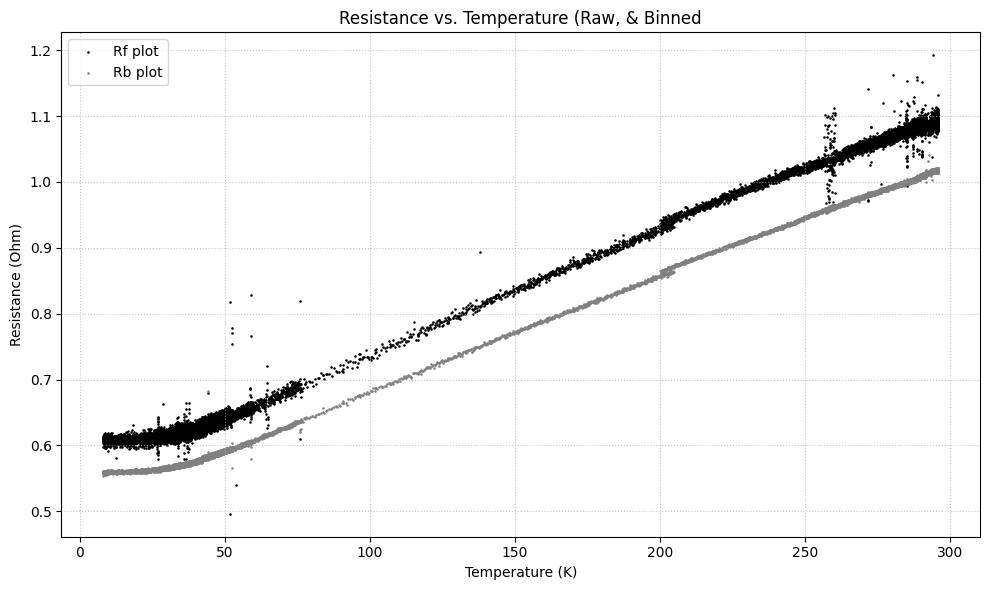

Text(0.5, 1.0, 'Sheet Resistance vs. Temperature')

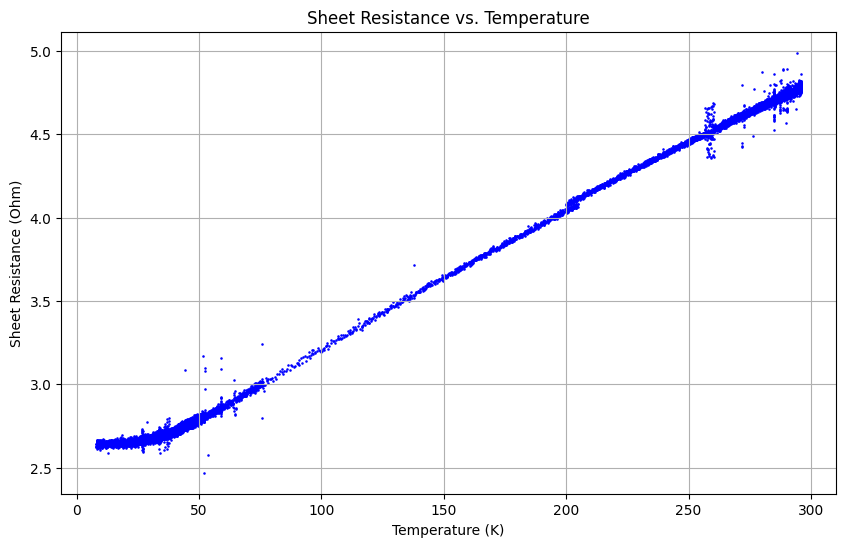

In [2]:
file_path = "DataSets/heating_8_to_296.dat"

# Load the data using pandas.
# sep='\s+' handles one or more spaces as delimiters.
# header=None indicates no header row.
# skipinitialspace=True handles potential leading spaces.
df = pd.read_csv(file_path, sep=r'\s+', header=None, skipinitialspace=True)

# The last row in your data might be incomplete. Remove any rows with NaN values if they appear.
df = df.dropna()

# front_temp (Column 6 -> index 5)
# front_temp_fluct (Column 7 -> index 6)
# front_R (Column 8 -> index 7)
# back_temp (Column 17 -> index 16)
# back_temp_fluct (Column 18 -> index 17)
# back_R (Column 19 -> index 18)

front_temp_raw = df.iloc[:, 5].astype(float)
front_temp_fluct_raw = df.iloc[:, 6].astype(float)
front_R = df.iloc[:, 7].astype(float)

back_temp_raw = df.iloc[:, 16].astype(float)
back_temp_fluct_raw = df.iloc[:, 17].astype(float)
back_R = df.iloc[:, 18].astype(float)

avg_temp = df.iloc[:, 26].astype(float)  


# # ---------------------------------------------
intra_cutoff = 0 # 30 mK
inter_cutoff = 0 # 10 uK

# # Create mask for filtering
sel_mask = (
    (front_temp_raw > 8) & (back_temp_raw > 8) &
    (front_temp_fluct_raw <= intra_cutoff) & (back_temp_fluct_raw <= intra_cutoff) & 
    (abs(front_temp_raw - back_temp_raw) == inter_cutoff)
)

# # Apply mask
Rf = front_R[sel_mask].values
Rb = back_R[sel_mask].values
Tavg = avg_temp[sel_mask].values
Tf = front_temp_raw[sel_mask].values
Tb = back_temp_raw[sel_mask].values

print(len(Tf))
print(len(Tb))

i=0
for i in range(len(Tf)):
    if (abs(Tf[i]-Tb[i])>0) : print(i)


# # ---------------------------------------------
Rs = np.zeros(len(Rf))
i = 0
while i < len(Rf):
    Rs[i] = calculate_sheet_resistance_vdp(Rf[i], Rb[i])
    i += 1  


# # ---------------------------------------------
plt.figure(figsize=(10, 6))
#plt.scatter(Tavg, Rf, s=10, label="Rf scatter", alpha=0.6)
plt.scatter(Tf, Rf, s = .7, color='black', label="Rf plot")
#plt.scatter(Tavg, Rb, s=10, label="Rb scatter", alpha=0.6)
plt.scatter(Tb, Rb, s = .7, color='gray', label="Rb plot")
plt.xlabel("Temperature (K)")
plt.ylabel("Resistance (Ohm)")
plt.title("Resistance vs. Temperature (Raw, & Binned")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()


# # ---------------------------------------------
plt.figure(figsize=(10, 6))
plt.grid()
plt.scatter(Tf, Rs, s = .7, color='blue', label='Sheet Resistance (VdP)')
plt.xlabel("Temperature (K)")
plt.ylabel("Sheet Resistance (Ohm)")
plt.title("Sheet Resistance vs. Temperature")

### $\rho_0$

Rho_0:  [2.64270235]
Rho_0 uncertainty: [0.4624039]


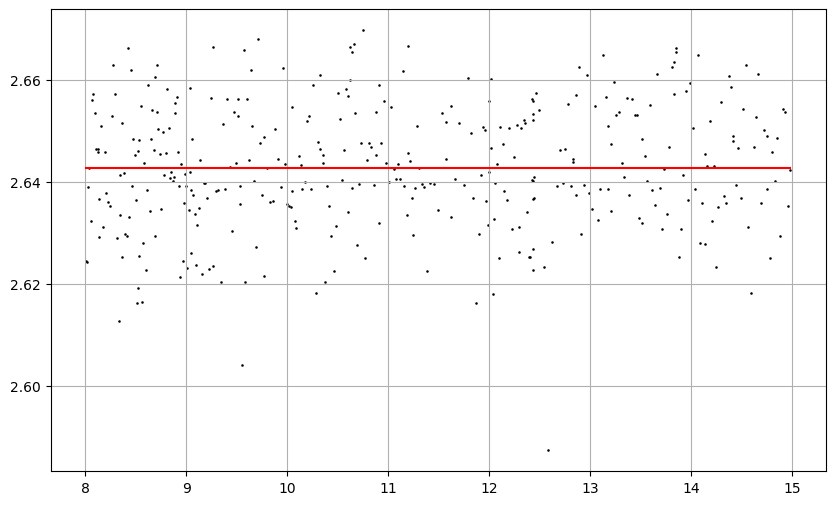

In [ ]:
T_sub = []
Rs_sub = []

i=0
while (Tf[i]<15): 
    T_sub.append(Tf[i])
    Rs_sub.append(Rs[i])
    i+=1


coeff = np.polyfit(T_sub, Rs_sub, deg=0)
Rho_0 = coeff
uncertainty_Rho0 = np.std(Rs_sub)

print("Rho_0: ", Rho_0)
print("Rho_0 uncertainty:", (uncertainty_Rho0/Rho_0)*100)

plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(T_sub, np.polyval(coeff, T_sub), color='red', label='Fit: Rho_0')
plt.scatter(T_sub, Rs_sub, s = .7, color='black', label="Rf plot")

### $\rho_{300}$

Delta_a = 6.693110110728548e-05
Delta_b = 0.01935786706636744 

Rho_300 = 4.670027005442278
Rho_300 uncertainty = 0.03809878306361411


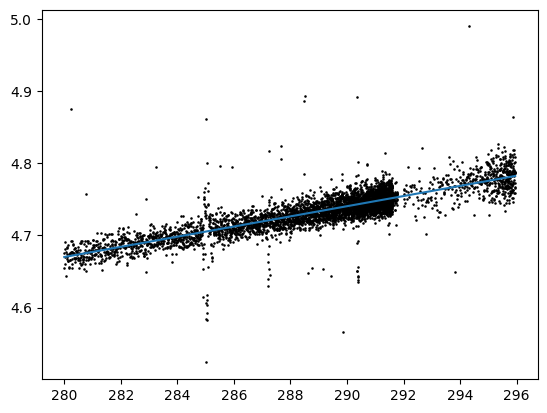

In [31]:
T_sub_up = []
Rs_sub_up = []

i= len(Tf)-1
while (Tf[i]>280): 
    T_sub_up.append(Tf[i])
    Rs_sub_up.append(Rs[i])
    i-=1

coeff_up = np.polyfit(T_sub_up, Rs_sub_up, deg=1, cov = True)
a, cov = coeff_up
stddev_a = np.sqrt(np.diag(cov))

k = len(T_sub_up)-1
Rho_300 = np.poly1d(coeff_up[0])(T_sub_up)[k]
print('Delta_a =', stddev_a[0])
print('Delta_b =', stddev_a[1], '\n')
print('Rho_300 =', Rho_300)

uncertainty_Rho300 = T_sub_up[k]*stddev_a[0] + stddev_a[1]
print('Rho_300 uncertainty =', uncertainty_Rho300 )

#stddev = np.std(Rs_sub)
plt.plot(T_sub_up, np.poly1d(coeff_up[0])(T_sub_up))
plt.scatter(T_sub_up, Rs_sub_up, s = .7, color='black', label="Rf plot")

The uncertainty model is the following: $\delta R(T) = T \delta a + \delta b$

$  \delta R (T) = \sum_i |\frac{\partial R}{\partial x_i}| \delta x_i$    given    $ R(T) = aT+b$

In [32]:
RRR=Rho_300/Rho_0
print('RRR =', RRR)

uncertainty_RRR = ((uncertainty_Rho300/Rho_300) + (uncertainty_Rho0/Rho_0))*RRR
print('RRR uncertainty:', uncertainty_RRR)

RRR = [1.76714075]
RRR uncertainty: [0.02258793]


Functions to compute meanigful parameters to evaluate the quality of the fit


In [33]:
def reduced_chi_squared(y_obs, y_model, y_err, num_params):
    """
    Compute the reduced chi-squared statistic.

    Parameters:
    -----------
    y_obs : array_like
        Observed y-values (data)
    y_model : array_like
        Predicted y-values from your model
    y_err : array_like
        Uncertainties (errors) on the observed y-values
    num_params : int
        Number of fitted parameters in the model

    Returns:
    --------
    float
        Reduced chi-squared
    """
    residuals = (y_obs - y_model) / y_err
    chi2 = np.sum(residuals**2)
    dof = len(y_obs) - num_params
    return chi2 / dof


def r_squared(y_obs, y_model):
    """
    Compute the coefficient of determination R².

    Parameters:
    -----------
    y_obs : array_like
        Observed y-values (data)
    y_model : array_like
        Predicted y-values from the model

    Returns:
    --------
    float
        R² value (coefficient of determination)
    """
    ss_res = np.sum((y_obs - y_model) ** 2)              # residual sum of squares
    ss_tot = np.sum((y_obs - np.mean(y_obs)) ** 2)       # total sum of squares
    return 1 - (ss_res / ss_tot)


## fix $n$ by generating the $ln(\rho-\rho_0)$ vs $ln(T)$ fit

Using the Dataline-wise VDP data

To make this fit we have to face the problem that $\rho(T)-\rho_0 <0 $ for some T, in order to bypass it we fit the $\ln(\rho(T)-\rho_0 + \epsilon)$ function where $\epsilon > max(|\rho(T)-\rho_0|)$ for $T\in [7.5, 15]K$  (sbagliato)

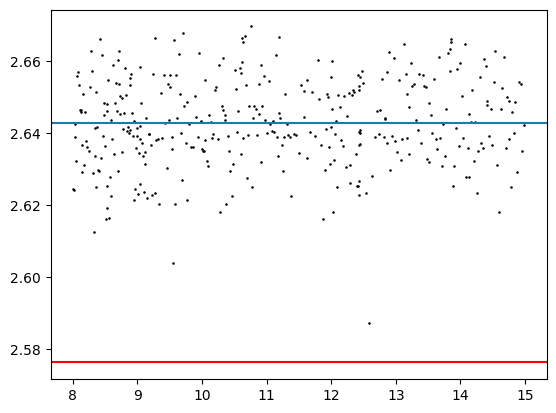

In [10]:
#define epsilon as 
max_deltaRs = 0
for i in range(len(T_sub)):
    if ((Rs[i]-Rho_0)<0 and np.abs(Rs[i]-Rho_0)> max_deltaRs): max_deltaRs = np.abs(Rs[i]-Rho_0) + .2*np.abs(Rs[i]-Rho_0)

plt.scatter(T_sub, Rs_sub, s = .7, color='black', label="Rf plot")
plt.axhline(Rho_0)
plt.axhline(Rho_0-max_deltaRs, color = 'red')

In [11]:
# # filter all the point that are outside the max_deltaRs bound
# Tf_clean = []
# Rs_clean = []
# for i in range(len(Tf)):
#     if ( Rs[i] > (Rho_0 - max_deltaRs)): 
#         Rs_clean.append(Rs[i])
#         Tf_clean.append(Tf[i])

# plt.figure(figsize=(10, 6))
# plt.grid()
# plt.scatter(Tf_clean, Rs_clean, s = .7, color='blue', label='Sheet Resistance (VdP)')

In [12]:
# plt.scatter(Tf_clean, Rs_clean - Rho_0, s = .7, color='blue')
# plt.axhline(max_deltaRs)

In [13]:
# print(min(Tf_clean),max(Tf_clean))

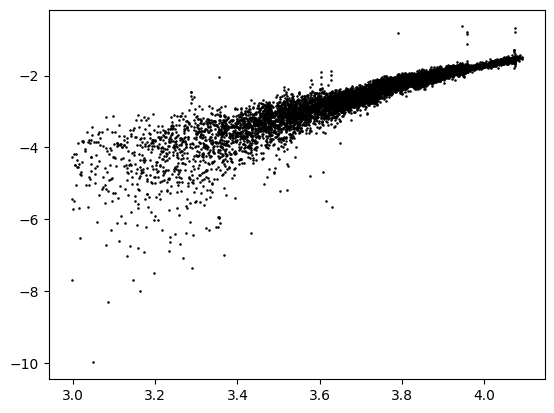

In [14]:
#filter the first portion of the curve
logT = []
logRR0 = []
T_comp = []
Rs_comp = []
t_u = 60
t_l = 20
i=0
j=0
while (Tf[i]<t_u): 
    if ((Tf[i]> t_l) and  (Rs[i]- Rho_0 )>0):
        # T_comp.append(Tf[i])
        # Rs_comp.append(Rs[i])
        logT.append(np.log(Tf[i]))
        logRR0.append(np.log(Rs[i]- Rho_0))
        #logRR0.append(np.log(np.abs(Rs[i]- Rho_0 )))
    i+=1

while (Tf[j]<t_u): 
    if ((Tf[j]> t_l)):
        T_comp.append(Tf[j])
        Rs_comp.append(Rs[j])
    j+=1

plt.scatter(logT, logRR0, s = .7, color='black', label="Rf plot")

params: [  3.32123039 -14.87525984]
COV: [[ 0.0002333  -0.00086534]
 [-0.00086534  0.00322021]]
stdev: [0.01527413 0.05674685]


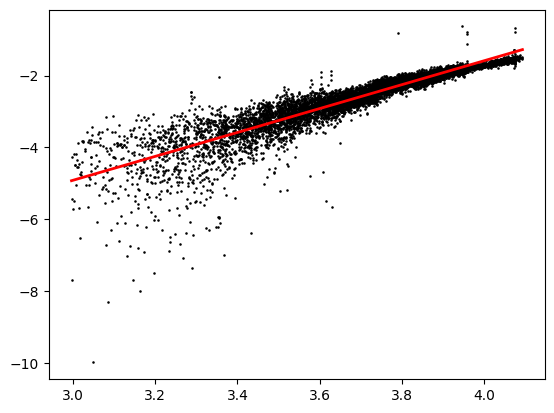

In [15]:
coeff_log = np.polyfit(logT, logRR0, deg=1, cov = True)
params, cov = coeff_log

params = np.squeeze(params)
cov = np.squeeze(cov)
print('params:',params)
print('COV:',cov)
print('stdev:', np.sqrt(np.diag(cov)))

plt.scatter(logT, logRR0, s = .7, color='black', label="Rf plot")
plt.plot(logT,np.poly1d(params)(logT), linewidth = 2, color = 'red')
#plt.plot(logT,np.poly1d([2,-9.3])(logT), linewidth = 2, color = 'green')


Text(0.5, 1.0, 'Sheet Resistance vs. Temperature')

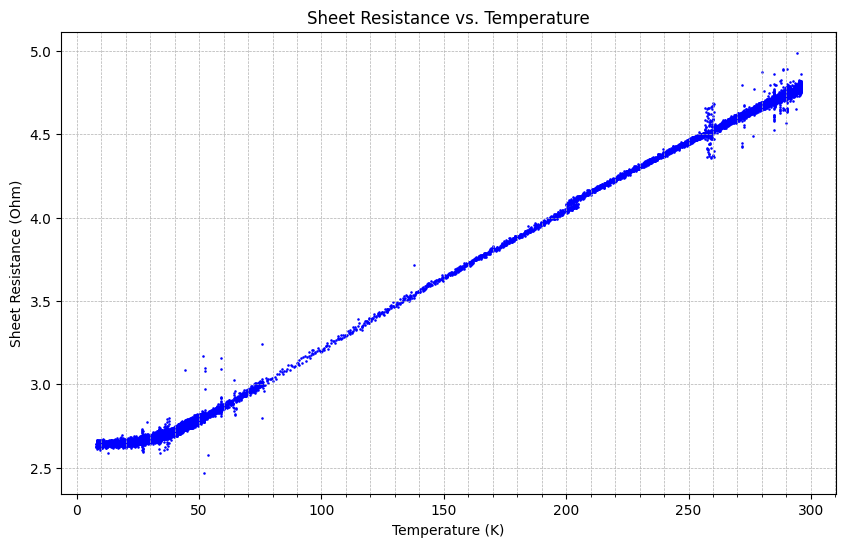

In [16]:


from matplotlib.ticker import AutoMinorLocator
# ax = plt.gca() # Get current axes
# ax.xaxis.set_minor_locator(AutoMinorLocator(5)) # Adds 4 minor ticks between major ticks (5 divisions)
#plt.grid(True, which='both', linestyle='--', linewidth=0.5) # Show grid for both major/minor ticks
plt.figure(figsize=(10, 6))
ax = plt.gca() # Get current axes
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.scatter(Tf, Rs, s = .7, color='blue', label='Sheet Resistance (VdP)')
plt.xlabel("Temperature (K)")
plt.ylabel("Sheet Resistance (Ohm)")
plt.title("Sheet Resistance vs. Temperature")

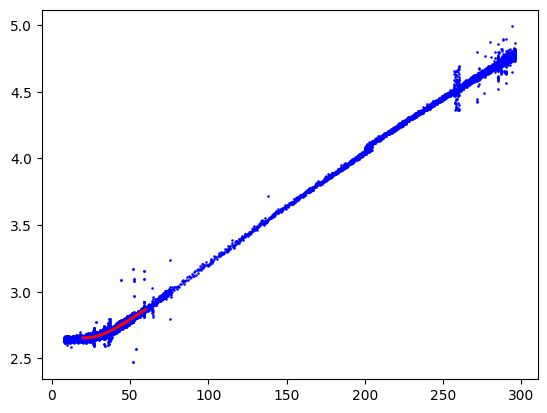

In [17]:
coeff_cmp = np.polyfit(T_comp, Rs_comp, deg=3.32)  #3.56
params = coeff_cmp

plt.scatter(T_comp, Rs_comp, s = .7, color='blue' )
plt.plot(T_comp, np.poly1d(coeff_cmp)(T_comp), linewidth = 2, color = 'red')
plt.scatter(Tf, Rs, s = .7, color='blue' )